In [438]:
#imports

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,ConfusionMatrixDisplay, precision_score, f1_score, silhouette_score
from sklearn.mixture import GaussianMixture as GMM
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import Birch, AgglomerativeClustering
from hmmlearn import hmm
from collections import OrderedDict
import pprint
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from tabulate import tabulate

In [277]:
# create list of df batchs
dfs = []

for i in range(1,11):
    df = pd.read_csv(f'batch{i}.dat', names=['Features'])
    
    df = df['Features'].str.split(pat=' ', n=128, expand=True)
    
    df.columns = ['Feature_'+str(i) for i in df.columns]
    
    df[['gas_type', 'ppmv']] = df['Feature_0'].str.split(pat=';', n=2, expand=True)
    df = df.drop(columns = ['Feature_0'])
    
    my_column_series = df.pop('ppmv')
    df.insert(0, 'ppmv', my_column_series)
    my_column_series = df.pop('gas_type')
    df.insert(0, 'gas_type', my_column_series)
    
    for j in df.columns:
        if j!='gas_type' and j!='ppmv':
            df[j] = df[j].str.split(':').str[1]
    
    df['batch']=i   
    columns = df.columns.tolist()
    df[columns] = df[columns].astype(float) 
    
    
    for k in range(6):
        df['gas_type'] = df['gas_type'].replace(k+1, k)
    
    df['gas_type'] = df['gas_type'].astype(int) 

        
    dfs.append(df)

/var/folders/qd/438shd_x19l09p0179z9d1p40000gp/T/ipykernel_61299/3442387542.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['batch']=i
/var/folders/qd/438shd_x19l09p0179z9d1p40000gp/T/ipykernel_61299/3442387542.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['batch']=i
/var/folders/qd/438shd_x19l09p0179z9d1p40000gp/T/ipykernel_61299/3442387542.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [444]:
# Computing external variables using a correlation matrix to each batch

external_variables_keys = []
external_variables_values = []
for idx, df in enumerate(dfs):
    corr_matrix = df.corr()
    external_variables_keys.append(corr_matrix['gas_type'].abs().sort_values().nlargest(n=4).keys().tolist()[1:])
    external_variables_values.append(corr_matrix['gas_type'].abs().sort_values().nlargest(n=4).tolist()[1:])
print('External variables keys:\n', external_variables_keys)
print('External variables values:\n', external_variables_values)

External variables keys:
 [['Feature_66', 'Feature_65', 'Feature_9'], ['Feature_72', 'Feature_16', 'Feature_9'], ['Feature_101', 'Feature_100', 'Feature_109'], ['Feature_108', 'Feature_100', 'Feature_124'], ['Feature_9', 'Feature_108', 'Feature_1'], ['Feature_109', 'Feature_125', 'Feature_53'], ['Feature_109', 'Feature_101', 'Feature_108'], ['Feature_28', 'Feature_45', 'Feature_29'], ['Feature_96', 'Feature_94', 'Feature_95'], ['Feature_9', 'Feature_11', 'Feature_12']]
External variables values:
 [[0.5484831184919605, 0.5455105265827529, 0.5242721963613607], [0.765155032548937, 0.7522570366355089, 0.7449397893397243], [0.7748037171179486, 0.7594207531919357, 0.7582319224128118], [0.7614226259094876, 0.7288363991920882, 0.7086598164150627], [0.677146231905575, 0.6376691918163716, 0.6350654885976297], [0.7389982037160554, 0.7252746492178699, 0.7242792192479142], [0.6645825824363056, 0.6566411460109138, 0.6515586993206833], [0.5630219964730646, 0.5557010896907087, 0.5536304088679754], [0.

In [472]:
# Table for PDF - find top 3 external variables

index_names = ["Batch1", "Batch2", "Batch3", "Batch4", "Batch5", "Batch6", "Batch7", "Batch8", "Batch9", "Batch10"]

table = []

for idx in range(len(index_names)):
    table.append([f'({feature}, {value})' for feature, value in zip(external_variables_keys[idx], external_variables_values[idx])])

print(tabulate(table, headers=["Feature 1st", "Feature 2nd", "Feature 3rd"], showindex=index_names, tablefmt="latex"))

\begin{tabular}{llll}
\hline
         & Feature 1st                       & Feature 2nd                       & Feature 3rd                       \\
\hline
 Batch1  & (Feature\_66, 0.5484831184919605)  & (Feature\_65, 0.5455105265827529)  & (Feature\_9, 0.5242721963613607)   \\
 Batch2  & (Feature\_72, 0.765155032548937)   & (Feature\_16, 0.7522570366355089)  & (Feature\_9, 0.7449397893397243)   \\
 Batch3  & (Feature\_101, 0.7748037171179486) & (Feature\_100, 0.7594207531919357) & (Feature\_109, 0.7582319224128118) \\
 Batch4  & (Feature\_108, 0.7614226259094876) & (Feature\_100, 0.7288363991920882) & (Feature\_124, 0.7086598164150627) \\
 Batch5  & (Feature\_9, 0.677146231905575)    & (Feature\_108, 0.6376691918163716) & (Feature\_1, 0.6350654885976297)   \\
 Batch6  & (Feature\_109, 0.7389982037160554) & (Feature\_125, 0.7252746492178699) & (Feature\_53, 0.7242792192479142)  \\
 Batch7  & (Feature\_109, 0.6645825824363056) & (Feature\_101, 0.6566411460109138) & (Feature\_108, 0.6515

In [427]:
# Example for one of the dfs
dfs[0]

,gas_type,ppmv,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_120,Feature_121,Feature_122,Feature_123,Feature_124,Feature_125,Feature_126,Feature_127,Feature_128,batch
0,0,10.0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,...,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529,1.0
1,0,20.0,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,...,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225,1.0
2,0,30.0,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,...,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370,1.0
3,0,40.0,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,...,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957,1.0
4,0,50.0,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,...,-4.181920,8158.6449,7.174334,1.993808,3.829303,4.402448,-1.930107,-2.931265,-4.088756,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,5,10.0,74805.0518,6.707129,15.446750,19.415134,20.782742,-12.073277,-15.890503,-33.655074,...,-1.928152,3208.7706,3.548801,0.692627,0.992265,1.274428,-0.481713,-0.705449,-2.153036,1.0
441,5,15.0,92035.5156,7.775487,21.173590,27.620422,29.159638,-14.717438,-17.631495,-21.352693,...,-2.734727,4009.7310,4.051835,0.983568,1.454702,1.736482,-0.648578,-1.101465,-3.118286,1.0
442,5,20.0,107898.2334,8.994761,25.131079,33.771374,37.121172,-17.064423,-23.058288,-66.829676,...,-1.539648,4834.6333,4.605179,1.218879,1.846645,2.245026,-0.831980,-1.299345,-3.860362,1.0
443,5,25.0,119795.0352,9.582606,28.944716,39.290350,41.062943,-18.824844,-22.903238,-29.631211,...,-3.688803,5555.9392,5.015334,1.413263,2.199541,3.252978,-0.970762,-1.693868,-2.720472,1.0


In [464]:
def plot(X, y, pred_, idx):
    mds = MDS(n_components=2)
    X_mds = mds.fit_transform(X)
    data = pd.DataFrame(data = X_mds, columns = ['x','y'])
    data['true'] = y
    data['pred'] = pred_
    

    # Set the color palette
    palette = sns.color_palette("bright", 6)
    with sns.axes_style("darkgrid"):

        # Create a scatterplot with large points for the ground truth labels
        sns.scatterplot(x="x", y="y", hue="true", data=data, s=300, palette=palette[0:len(set(data['true']))], alpha=0.2)

        # Overlay a scatterplot with smaller points for the predicted labels
        sns.scatterplot(x="x", y="y", hue="pred", data=data, s=25, palette=palette[0:len(set(data['pred']))], alpha=1)   
    
    # Add a legend with modified labels
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [f'{i}' for i in range(max(len(set(data['true'])), len(set(data['pred']))))]
    plt.legend(handles, labels)
    # plt.savefig(f'plot_gas_batch{idx+1}.png')
    # Show the plot
    plt.show()
    
def _make_cost_m(cm, shape):
    s = np.max(cm, axis=1)
    s = np.array(s)
    s = s.reshape((shape,1))
    return (- cm + s)

def printmd(string):
    display(Markdown(string))

def resultsPerModel(dfs, model, Visualization = False, anomaly = False, external_variables_keys_ = None):
    accuracy = []
    precision = []
    silhouette = []
    F1_score = []
    if anomaly:
        external_variables_values_ = []
    for idx,df in enumerate(dfs):
        printmd(f'**Batch{idx+1}**')
        
        if anomaly:
            temp = df.copy()
            for i in df.columns.tolist()[1:]:
                mean = df[i].mean()
                std = df[i].std()
                # calculate upper threshold
                threshold_1 = mean + 3*std
                threshold_2 = mean - 3*std
                # select rows where feature is less than or equal to threshold
                df = df[(df[i] >= threshold_2) & (df[i] <= threshold_1)]

            df_only_anomaly = pd.merge(temp,df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
            external_variables_keys_[idx].append('gas_type')
            df_only_anomaly = df_only_anomaly[external_variables_keys_[idx]]
            corr_matrix = df_only_anomaly.corr()
            external_variables_values_.append(corr_matrix['gas_type'].abs().sort_values().nlargest(n=4).tolist()[1:])

        
        y = df['gas_type']
        X = df.iloc[:, 1:130]
        if hasattr(model, "fit_predict"):
            pred = model.fit_predict(X)
        else:
            pred = model.fit(X).predict(X)

        # True lables
        print("True lables:")
        print(y.value_counts().sort_index().to_dict(),'\n')

        # Prediction
        pred_labels = {}
        for item in pred:
            pred_labels[item] = pred_labels.get(item, 0) + 1

        print("Prediction labels:")
        pprint.pprint(pred_labels, sort_dicts=True)
        print('\nConfusion matrix:')
        cm = confusion_matrix(y,pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(max(len(np.unique(y)), len(set(pred))))])
        disp.plot()
        plt.show()

        # Reordering confusion matrix index columns
        indexes = linear_assignment(_make_cost_m(cm, max(len(y.value_counts()), len(set(pred)))))
        indexes = indexes[1].tolist()
        for ind, i in enumerate(pred):
            pred[ind]=indexes.index(i)

        pred_ = np.array([i for i in pred]) 
        pred_labels_reordering = {}
        for item in pred_:
            pred_labels_reordering[item] = pred_labels_reordering.get(item, 0) + 1
        print("Prediction labels after reordering:")
        pprint.pprint(pred_labels_reordering, sort_dicts=True)
        print('\nConfusion matrix after reordering columns:')
        cm_ = confusion_matrix(y, pred_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_, display_labels=[i for i in range(max(len(np.unique(y)), len(set(pred_))))])
        disp.plot()
        # plt.savefig(f'confusion_matrix_gas_batch{idx+1}.png')
        plt.show()

        # Metrics
        print('Metrics scores:')
        print("Accuracy:", accuracy_score(y,pred_))
        print("Precision:",precision_score(y, pred_, average='macro'))
        print("Silhouette_score:", silhouette_score(X, pred_))
        print("F1 score:", f1_score(y , pred_, average='macro'))
        accuracy.append(accuracy_score(y,pred_))
        precision.append(precision_score(y, pred_, average='macro'))
        silhouette.append(silhouette_score(X, pred_))
        F1_score.append(f1_score(y , pred_, average='macro'))
        
        if Visualization:
            print('\nVisualization:')
            plot_i = plot(X, y, pred_, idx)
            plots.append(plot_i)
            
    if anomaly:   
        return accuracy, precision, silhouette, F1_score, external_variables_values_
    else:
        return accuracy, precision, silhouette, F1_score

**Batch1**

True lables:
{0: 90, 1: 98, 2: 83, 3: 30, 4: 70, 5: 74} 

Prediction labels:
{0: 41, 1: 135, 2: 24, 3: 21, 4: 177, 5: 47}

Confusion matrix:


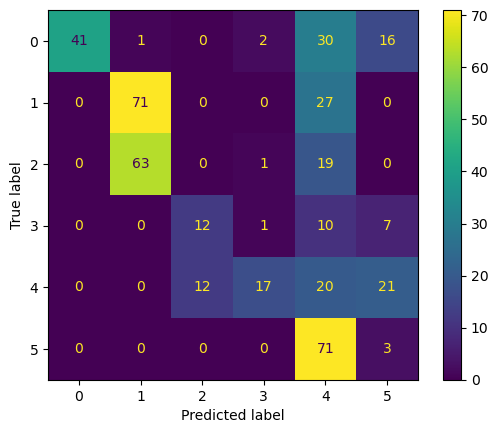

Prediction labels after reordering:
{0: 41, 1: 135, 2: 21, 3: 24, 4: 47, 5: 177}

Confusion matrix after reordering columns:


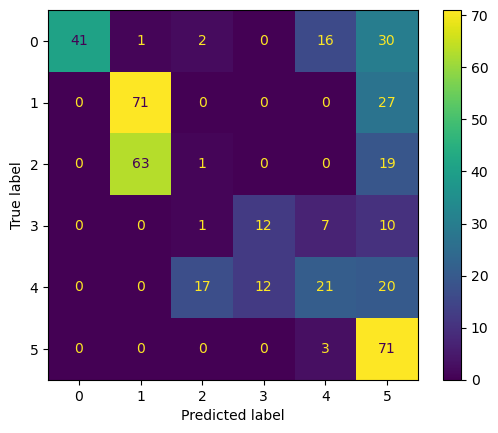

Metrics scores:
Accuracy: 0.48764044943820223
Precision: 0.48691390461434936
Silhouette_score: 0.0926244922862076
F1 score: 0.4372971471669201

Visualization:


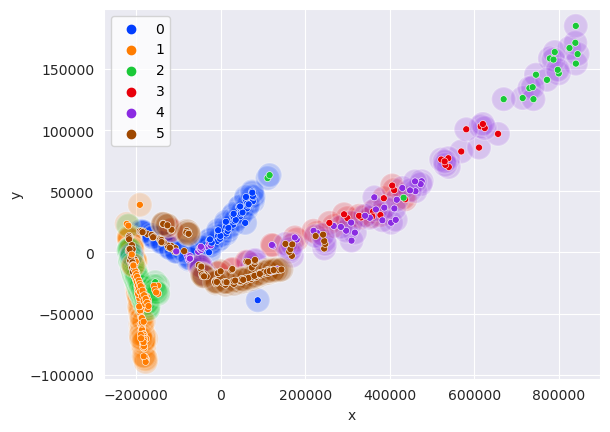

**Batch2**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 164, 1: 334, 2: 100, 3: 109, 4: 532, 5: 5} 

Prediction labels:
{0: 216, 1: 303, 2: 212, 3: 315, 4: 84, 5: 114}

Confusion matrix:


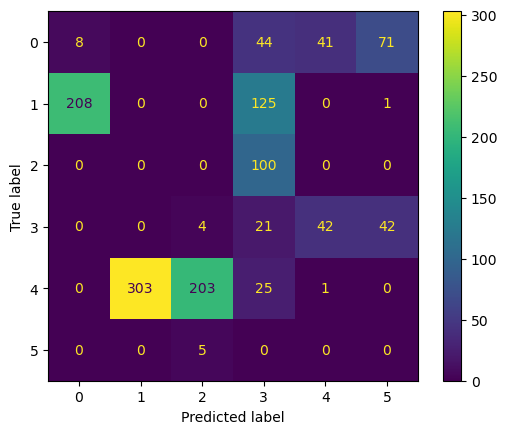

Prediction labels after reordering:
{0: 114, 1: 216, 2: 315, 3: 84, 4: 303, 5: 212}

Confusion matrix after reordering columns:


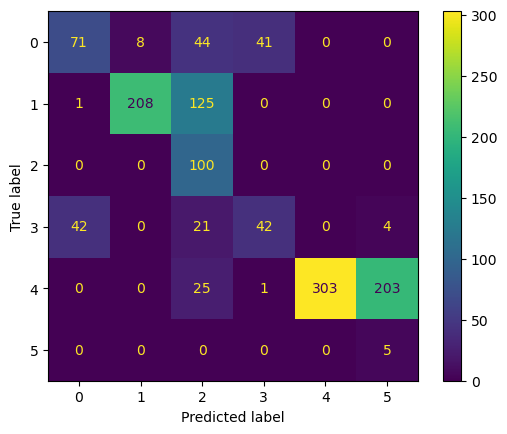

Metrics scores:
Accuracy: 0.5860128617363344
Precision: 0.5711358672712529
Silhouette_score: 0.4058071858998451
F1 score: 0.4926912211730024

Visualization:


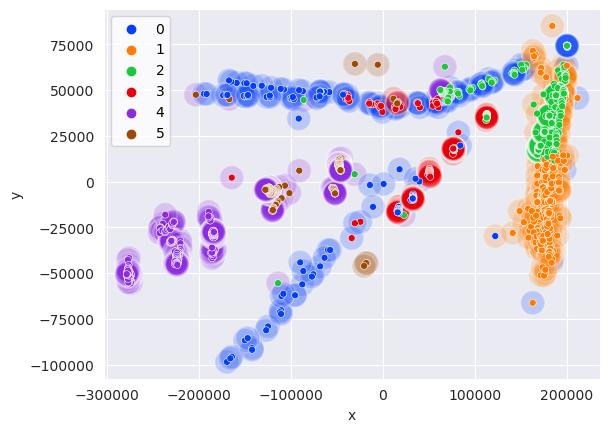

**Batch3**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 365, 1: 490, 2: 216, 3: 240, 4: 275} 

Prediction labels:
{0: 464, 1: 215, 2: 397, 3: 97, 4: 266, 5: 147}

Confusion matrix:


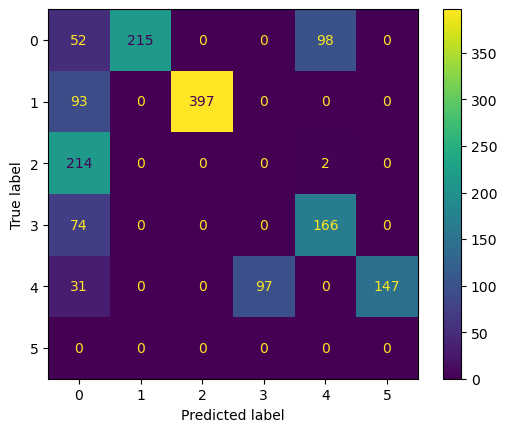

Prediction labels after reordering:
{0: 215, 1: 397, 2: 464, 3: 266, 4: 147, 5: 97}

Confusion matrix after reordering columns:


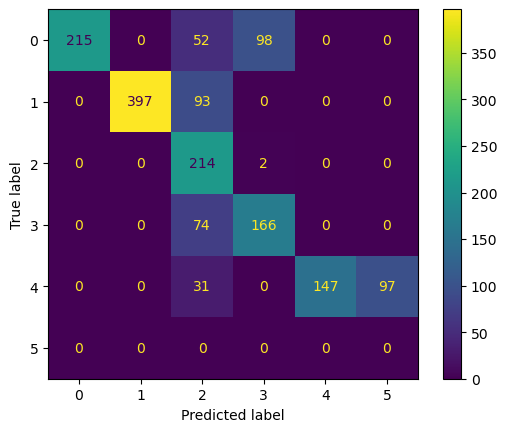

Metrics scores:
Accuracy: 0.7181588902900379
Precision: 0.6808778411546106
Silhouette_score: 0.5058508622377449
F1 score: 0.6031253700234618

Visualization:


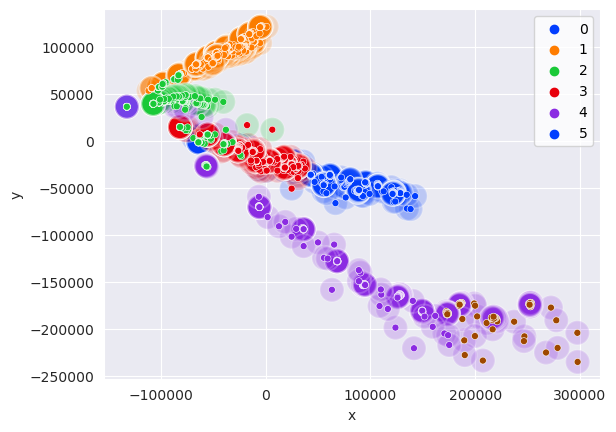

**Batch4**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 64, 1: 43, 2: 12, 3: 30, 4: 12} 

Prediction labels:
{0: 45, 1: 26, 2: 12, 3: 19, 4: 38, 5: 21}

Confusion matrix:


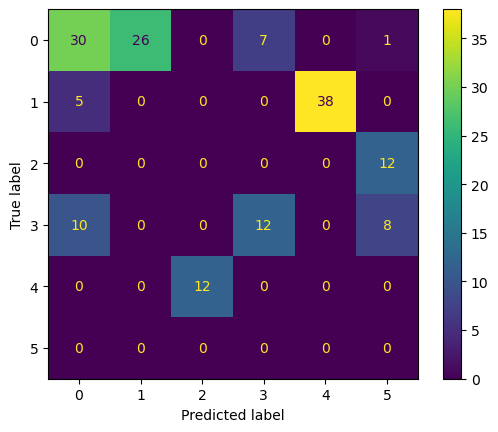

Prediction labels after reordering:
{0: 45, 1: 38, 2: 21, 3: 19, 4: 12, 5: 26}

Confusion matrix after reordering columns:


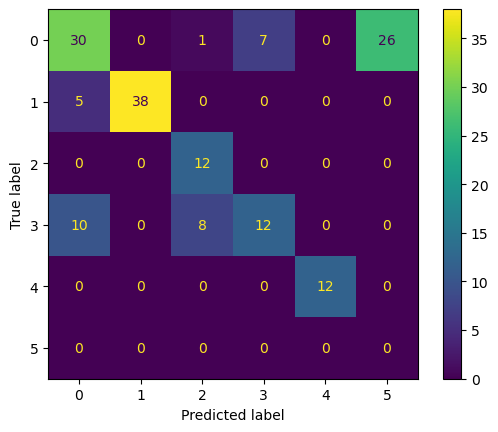

Metrics scores:
Accuracy: 0.6459627329192547
Precision: 0.6449456975772766
Silhouette_score: 0.6581185267395816
F1 score: 0.6176331610291127

Visualization:


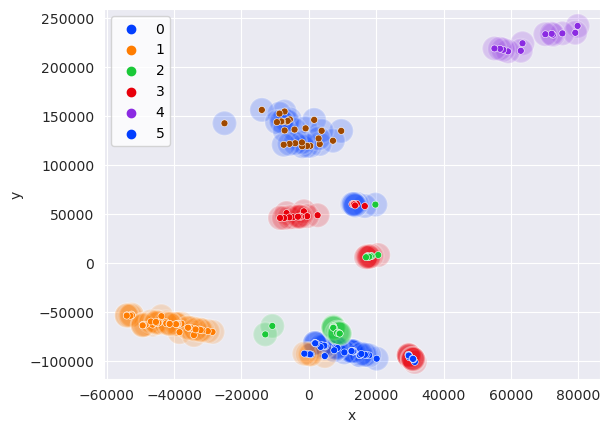

**Batch5**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 28, 1: 40, 2: 20, 3: 46, 4: 63} 

Prediction labels:
{0: 20, 1: 61, 2: 58, 3: 39, 4: 3, 5: 16}

Confusion matrix:


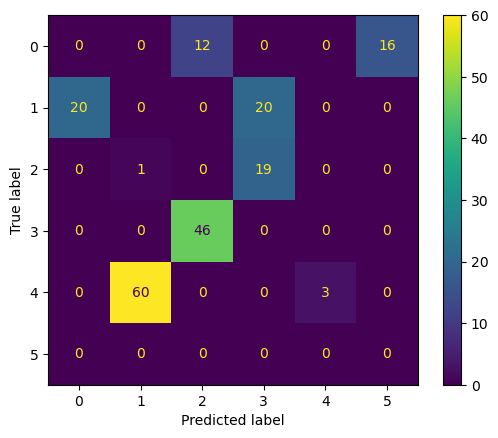

Prediction labels after reordering:
{0: 16, 1: 20, 2: 39, 3: 58, 4: 61, 5: 3}

Confusion matrix after reordering columns:


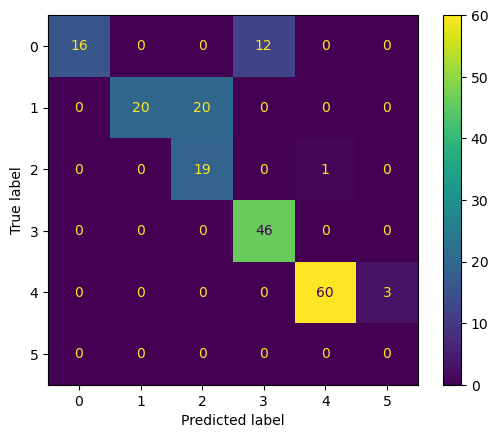

Metrics scores:
Accuracy: 0.817258883248731
Precision: 0.7106482488053998
Silhouette_score: 0.7700642542032761
F1 score: 0.6483940851081366

Visualization:


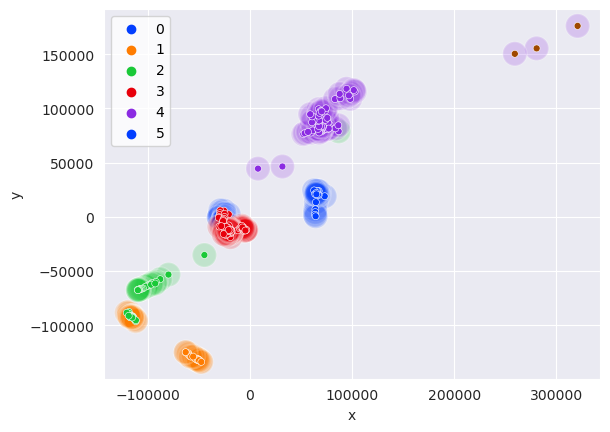

**Batch6**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 514, 1: 574, 2: 110, 3: 29, 4: 606, 5: 467} 

Prediction labels:
{0: 532, 1: 206, 2: 475, 3: 472, 4: 312, 5: 303}

Confusion matrix:


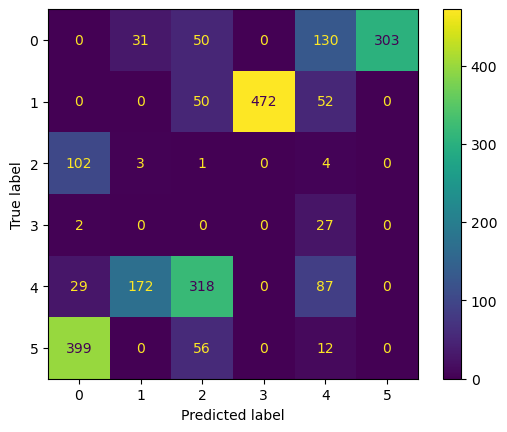

Prediction labels after reordering:
{0: 303, 1: 472, 2: 206, 3: 312, 4: 475, 5: 532}

Confusion matrix after reordering columns:


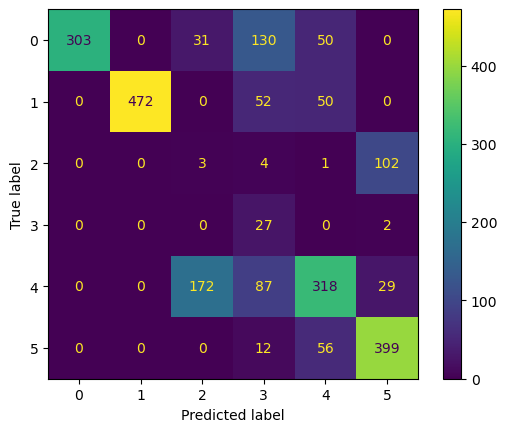

Metrics scores:
Accuracy: 0.6617391304347826
Precision: 0.5867625420908508
Silhouette_score: 0.3251991082203661
F1 score: 0.534785293898781

Visualization:


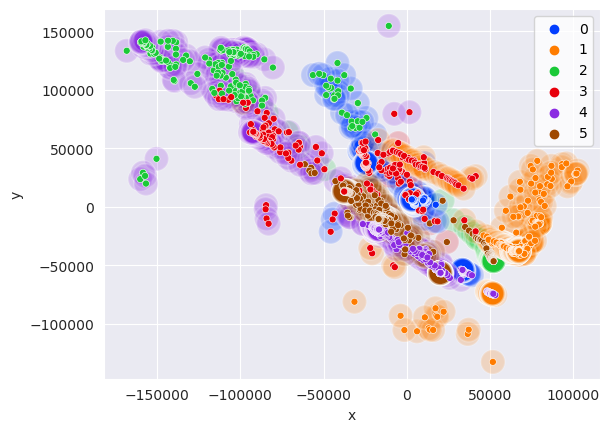

**Batch7**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 649, 1: 662, 2: 360, 3: 744, 4: 630, 5: 568} 

Prediction labels:
{0: 853, 1: 490, 2: 351, 3: 466, 4: 1152, 5: 301}

Confusion matrix:


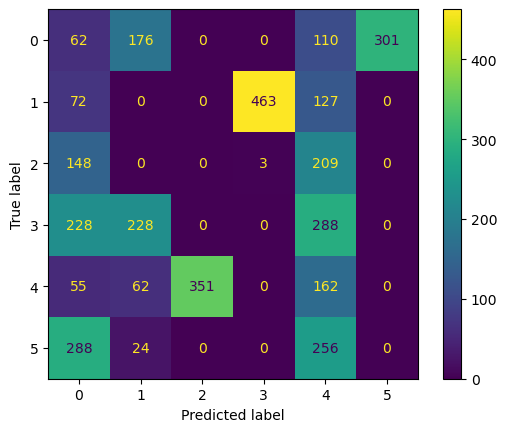

Prediction labels after reordering:
{0: 301, 1: 466, 2: 1152, 3: 490, 4: 351, 5: 853}

Confusion matrix after reordering columns:


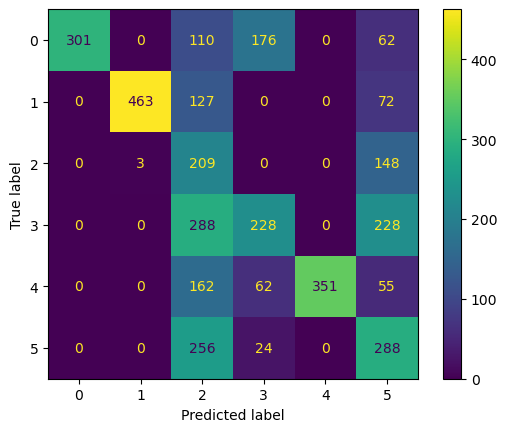

Metrics scores:
Accuracy: 0.5092720730694713
Precision: 0.6629873087959641
Silhouette_score: 0.2437363229228577
F1 score: 0.5369226471832942

Visualization:


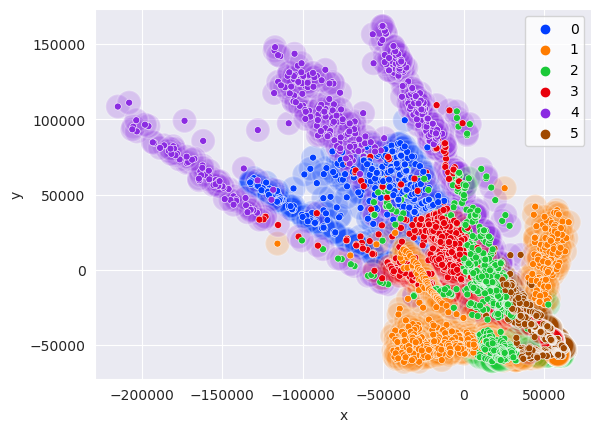

**Batch8**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 30, 1: 30, 2: 40, 3: 33, 4: 143, 5: 18} 

Prediction labels:
{0: 31, 1: 76, 2: 124, 3: 3, 4: 30, 5: 30}

Confusion matrix:


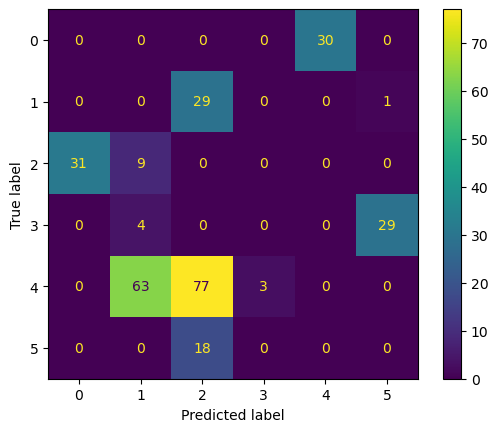

Prediction labels after reordering:
{0: 30, 1: 124, 2: 31, 3: 30, 4: 76, 5: 3}

Confusion matrix after reordering columns:


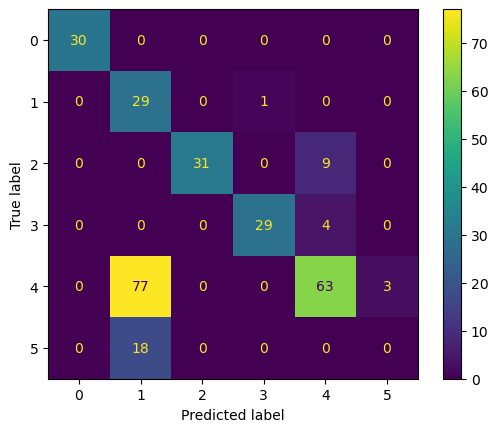

Metrics scores:
Accuracy: 0.6190476190476191
Precision: 0.6715808338049425
Silhouette_score: 0.3575107052470784
F1 score: 0.6243066999385734

Visualization:


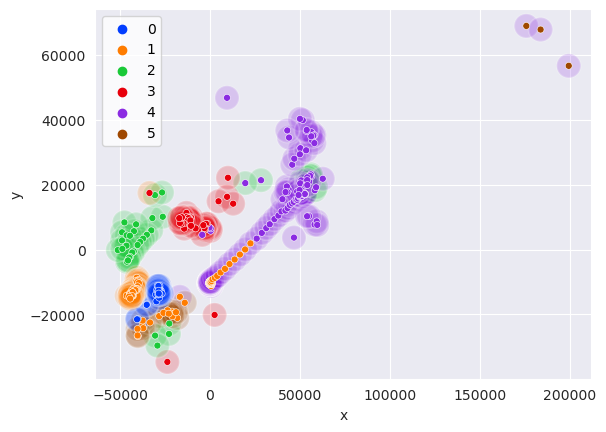

**Batch9**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 61, 1: 55, 2: 100, 3: 75, 4: 78, 5: 101} 

Prediction labels:
{0: 158, 1: 50, 2: 100, 3: 41, 4: 92, 5: 29}

Confusion matrix:


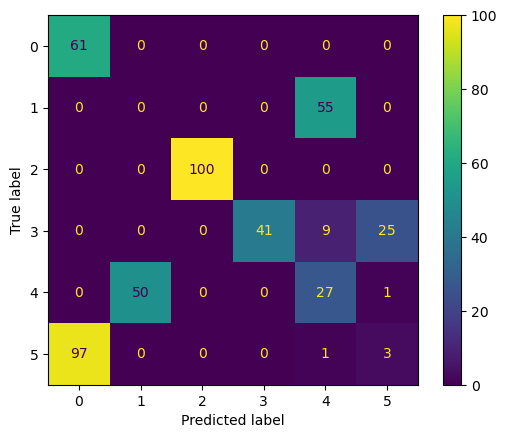

Prediction labels after reordering:
{0: 29, 1: 92, 2: 100, 3: 41, 4: 50, 5: 158}

Confusion matrix after reordering columns:


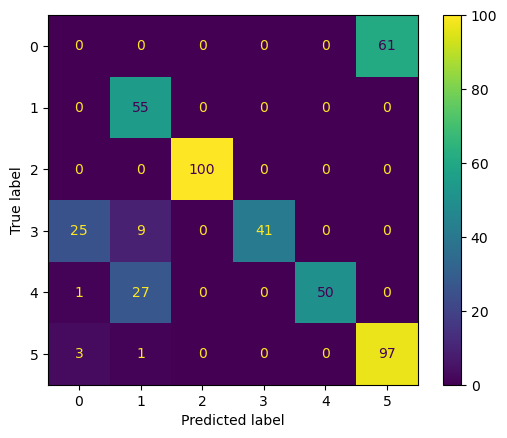

Metrics scores:
Accuracy: 0.7297872340425532
Precision: 0.7019583562649054
Silhouette_score: 0.5758784594118908
F1 score: 0.6642467700811296

Visualization:


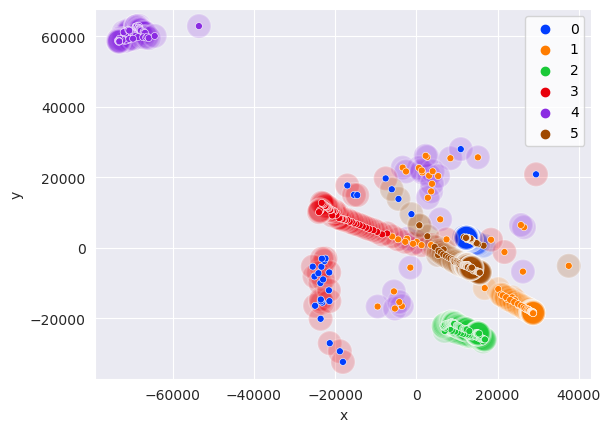

**Batch10**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600} 

Prediction labels:
{0: 1059, 1: 323, 2: 765, 3: 613, 4: 196, 5: 644}

Confusion matrix:


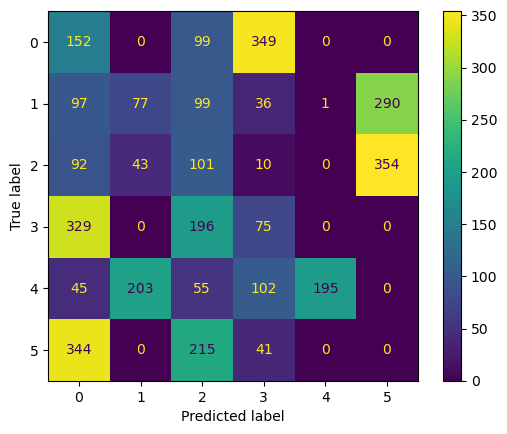

Prediction labels after reordering:
{0: 613, 1: 323, 2: 644, 3: 1059, 4: 196, 5: 765}

Confusion matrix after reordering columns:


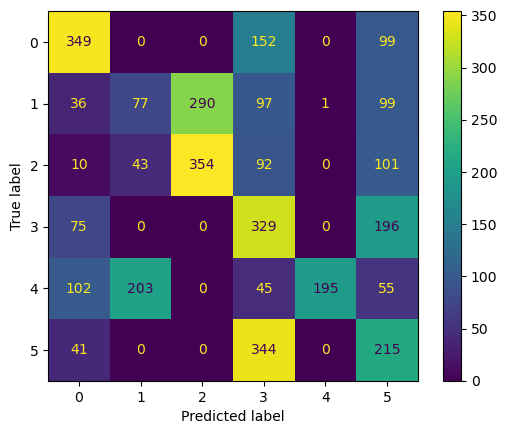

Metrics scores:
Accuracy: 0.42194444444444446
Precision: 0.49067080779063316
Silhouette_score: 0.30660075364778394
F1 score: 0.41883406960249087

Visualization:


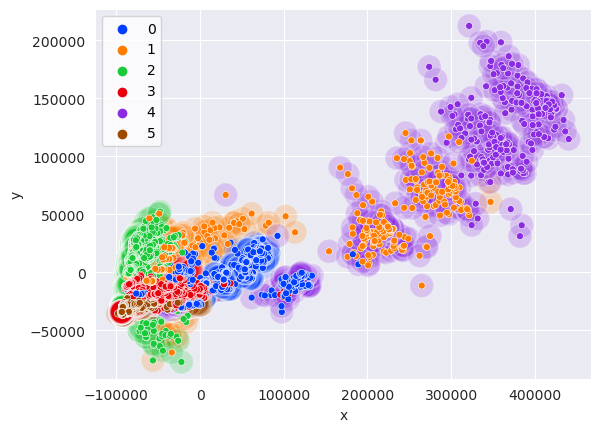

In [463]:
# HMM
accuracy_HMM = []
precision_HMM = []
silhouette_HMM = []
f1_score_HMM = []

HMM = hmm.GaussianHMM(n_components=6)
accuracy_HMM, precision_HMM, silhouette_HMM, f1_score_HMM = resultsPerModel(dfs, HMM, Visualization = True)

In [ ]:
# Birch
accuracy_Birch = []
precision_Birch= []
silhouette_Birch= []
f1_score_Birch= []

birch = Birch(n_clusters=6).fit(df_scaled)
accuracy_Birch, precision_Birch, silhouette_Birch, f1_score_Birch = resultsPerModel(dfs, birch, Visualization = False)

**Batch1**

True lables:
{0: 90, 1: 98, 2: 83, 3: 30, 4: 70, 5: 74} 

Prediction labels:
{0: 155, 1: 33, 2: 13, 3: 219, 4: 16, 5: 9}

Confusion matrix:


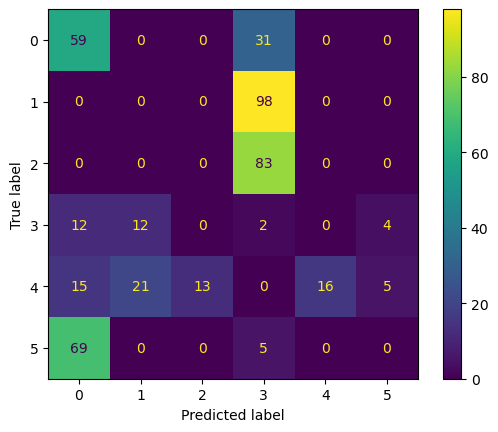

Prediction labels after reordering:
{0: 9, 1: 219, 2: 13, 3: 33, 4: 16, 5: 155}

Confusion matrix after reordering columns:


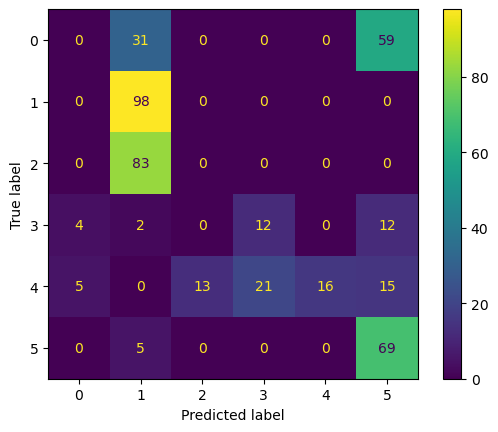

Metrics scores:
Accuracy: 0.43820224719101125
Precision: 0.3760477064056384
Silhouette_score: 0.6114943502429083
F1 score: 0.328993670252149


**Batch2**

True lables:
{0: 164, 1: 334, 2: 100, 3: 109, 4: 532, 5: 5} 

Prediction labels:
{0: 27, 1: 252, 2: 304, 3: 165, 4: 495, 5: 1}

Confusion matrix:


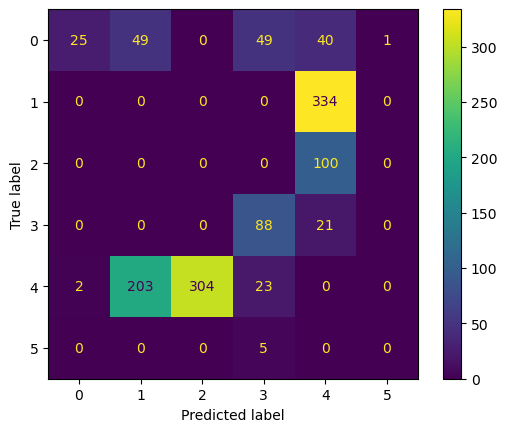

Prediction labels after reordering:
{0: 252, 1: 495, 2: 27, 3: 165, 4: 304, 5: 1}

Confusion matrix after reordering columns:


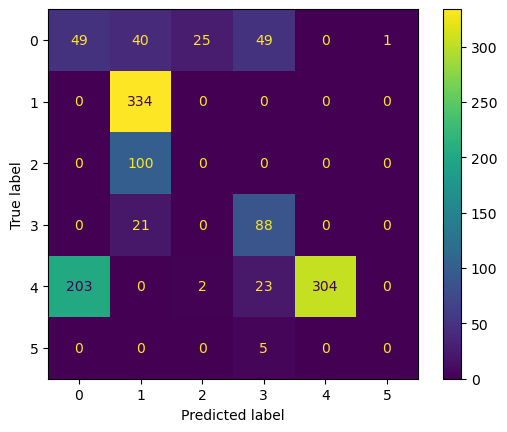

Metrics scores:
Accuracy: 0.6229903536977492
Precision: 0.4004208754208754
Silhouette_score: 0.46912675872886606
F1 score: 0.401829254222924


**Batch3**

True lables:
{0: 365, 1: 490, 2: 216, 3: 240, 4: 275} 

Prediction labels:
{0: 150, 1: 543, 2: 311, 3: 48, 4: 145, 5: 389}

Confusion matrix:


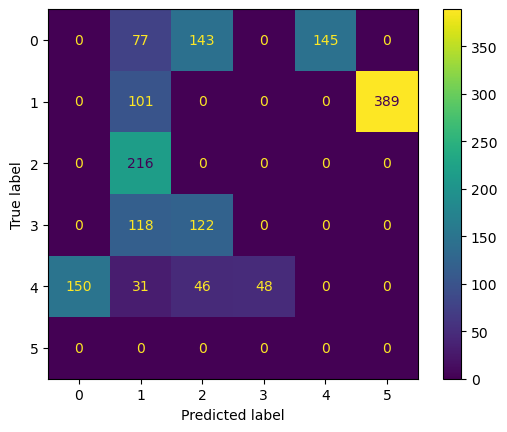

Prediction labels after reordering:
{0: 145, 1: 389, 2: 543, 3: 311, 4: 150, 5: 48}

Confusion matrix after reordering columns:


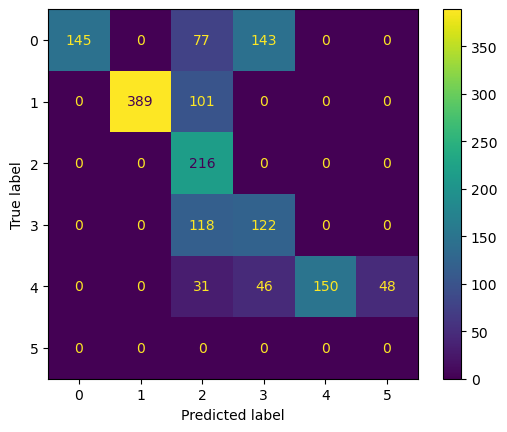

Metrics scores:
Accuracy: 0.6443883984867591
Precision: 0.6316788355746626
Silhouette_score: 0.504486432727392
F1 score: 0.5286012801938664


**Batch4**

True lables:
{0: 64, 1: 43, 2: 12, 3: 30, 4: 12} 

Prediction labels:
{0: 57, 1: 20, 2: 12, 3: 26, 4: 38, 5: 8}

Confusion matrix:


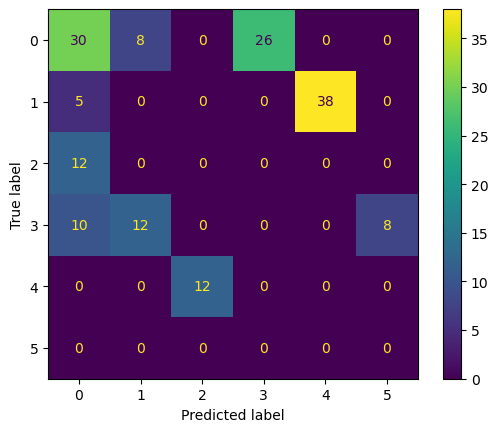

Prediction labels after reordering:
{0: 26, 1: 38, 2: 57, 3: 20, 4: 12, 5: 8}

Confusion matrix after reordering columns:


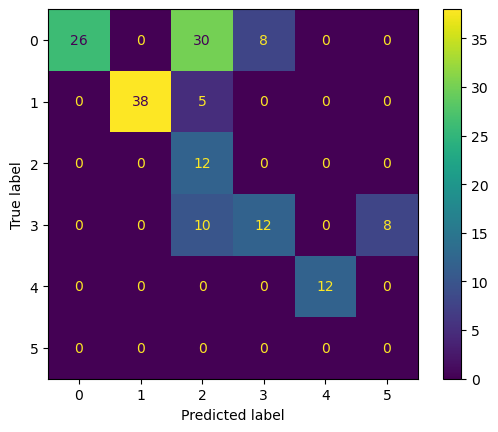

Metrics scores:
Accuracy: 0.6211180124223602
Precision: 0.6350877192982456
Silhouette_score: 0.7419302117153201
F1 score: 0.5573125782787618


**Batch5**

True lables:
{0: 28, 1: 40, 2: 20, 3: 46, 4: 63} 

Prediction labels:
{0: 3, 1: 18, 2: 59, 3: 59, 4: 20, 5: 38}

Confusion matrix:


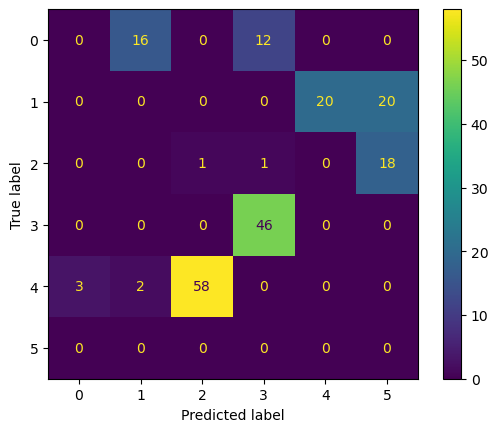

Prediction labels after reordering:
{0: 18, 1: 20, 2: 38, 3: 59, 4: 59, 5: 3}

Confusion matrix after reordering columns:


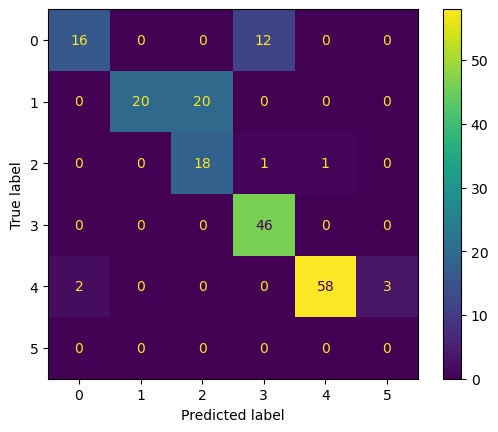

Metrics scores:
Accuracy: 0.8020304568527918
Precision: 0.6875474939703308
Silhouette_score: 0.7808734423839353
F1 score: 0.6350031073456246


**Batch6**

True lables:
{0: 514, 1: 574, 2: 110, 3: 29, 4: 606, 5: 467} 

Prediction labels:
{0: 795, 1: 279, 2: 6, 3: 6, 4: 1213, 5: 1}

Confusion matrix:


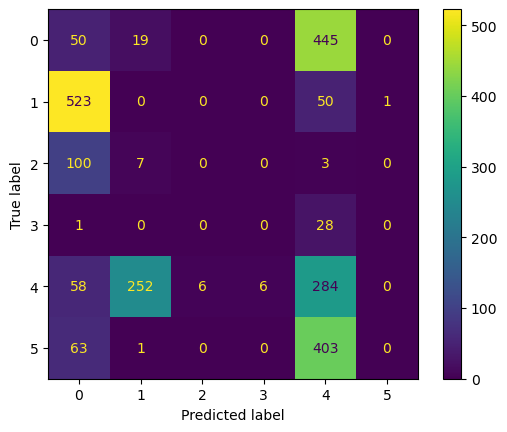

Prediction labels after reordering:
{0: 1213, 1: 795, 2: 6, 3: 6, 4: 279, 5: 1}

Confusion matrix after reordering columns:


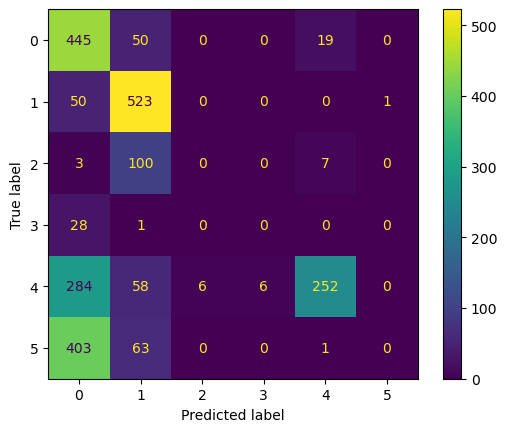

Metrics scores:
Accuracy: 0.5304347826086957
Precision: 0.32132441147950247
Silhouette_score: 0.5434348550354364
F1 score: 0.30814956869384397


**Batch7**

True lables:
{0: 649, 1: 662, 2: 360, 3: 744, 4: 630, 5: 568} 

Prediction labels:
{0: 2860, 1: 70, 2: 91, 3: 285, 4: 148, 5: 159}

Confusion matrix:


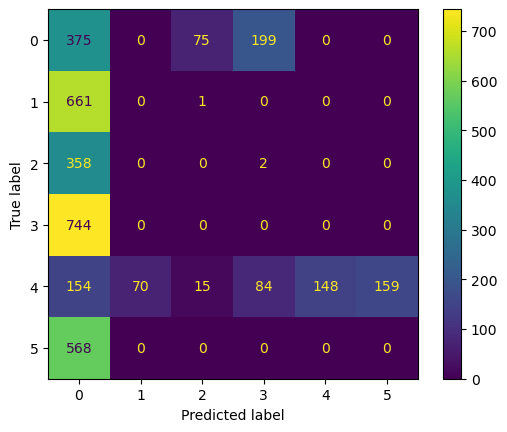

Prediction labels after reordering:
{0: 285, 1: 91, 2: 70, 3: 2860, 4: 159, 5: 148}

Confusion matrix after reordering columns:


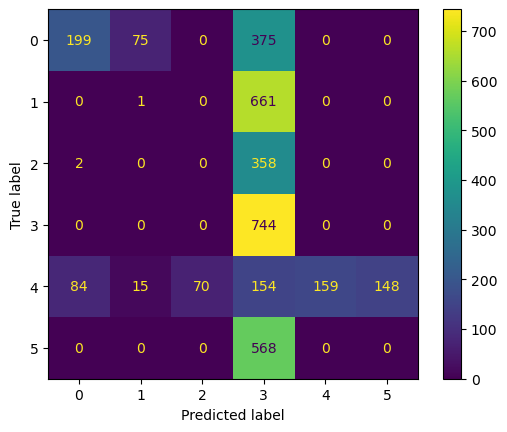

Metrics scores:
Accuracy: 0.30528646554110156
Precision: 0.32822908086065977
Silhouette_score: 0.4301498202428472
F1 score: 0.2074494413982768


**Batch8**

True lables:
{0: 30, 1: 30, 2: 40, 3: 33, 4: 143, 5: 18} 

Prediction labels:
{0: 111, 1: 105, 2: 65, 3: 1, 4: 3, 5: 9}

Confusion matrix:


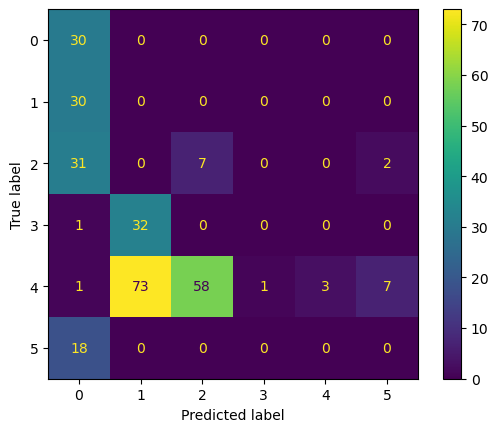

Prediction labels after reordering:
{0: 111, 1: 1, 2: 9, 3: 105, 4: 65, 5: 3}

Confusion matrix after reordering columns:


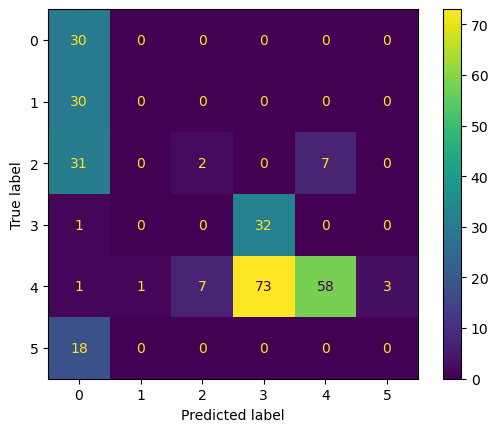

Metrics scores:
Accuracy: 0.41496598639455784
Precision: 0.28159368159368164
Silhouette_score: 0.5420351729122524
F1 score: 0.2547708319315297


**Batch9**

True lables:
{0: 61, 1: 55, 2: 100, 3: 75, 4: 78, 5: 101} 

Prediction labels:
{0: 46, 1: 328, 2: 4, 3: 50, 4: 41, 5: 1}

Confusion matrix:


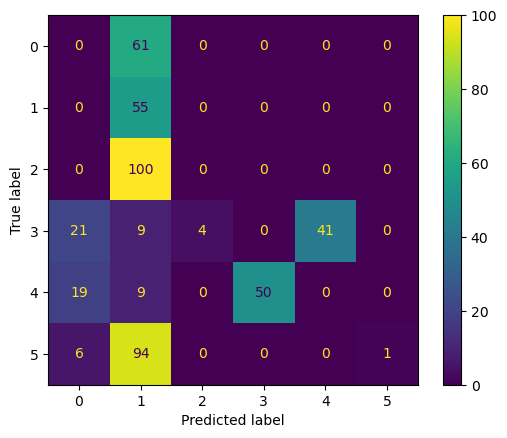

Prediction labels after reordering:
{0: 4, 1: 1, 2: 328, 3: 41, 4: 50, 5: 46}

Confusion matrix after reordering columns:


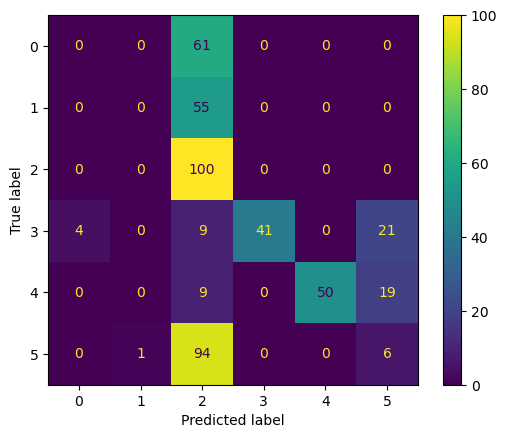

Metrics scores:
Accuracy: 0.41914893617021276
Precision: 0.40588547189819724
Silhouette_score: 0.4770910172410583
F1 score: 0.33951148740192183


**Batch10**

True lables:
{0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600} 

Prediction labels:
{0: 198, 1: 463, 2: 99, 3: 2737, 4: 2, 5: 101}

Confusion matrix:


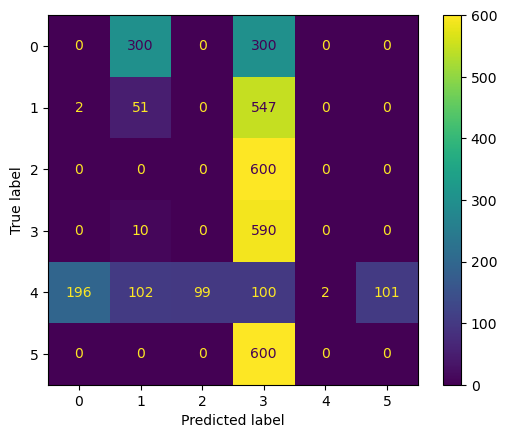

Prediction labels after reordering:
{0: 463, 1: 2, 2: 2737, 3: 99, 4: 198, 5: 101}

Confusion matrix after reordering columns:


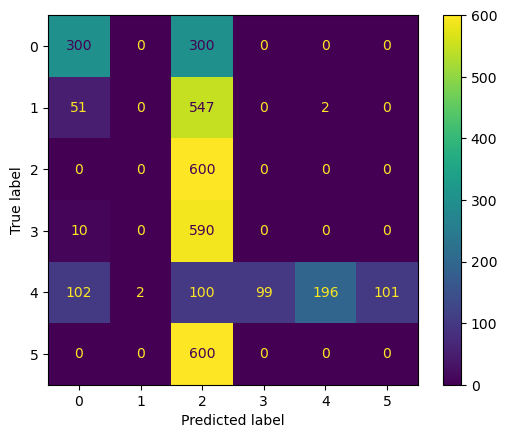

Metrics scores:
Accuracy: 0.30444444444444446
Precision: 0.3095108793462133
Silhouette_score: 0.5634990444865339
F1 score: 0.2358787947837102


In [364]:
# AgglomerativeClustering
accuracy_AgglomerativeClustering = []
precision_AgglomerativeClustering = []
silhouette_AgglomerativeClustering = []
f1_score_AgglomerativeClustering = []
precision_before_anomaly = []

agglomerativeClustering = AgglomerativeClustering(n_clusters=6, linkage='average')
accuracy_AgglomerativeClustering, precision_AgglomerativeClustering, silhouette_AgglomerativeClustering, f1_score_AgglomerativeClustering = resultsPerModel(dfs, agglomerativeClustering, Visualization = False)

In [465]:
# check best clustering algorithem by calculate each average metrics

# HMM
accuracy_HMM_average = np.average(accuracy_HMM)
precision_HMM_average = np.average(precision_HMM)
silhouette_HMM_norm = [(val+1) / 2 for val in silhouette_HMM]
silhouette_HMM_norm_average = np.average(silhouette_HMM_norm)
f1_score_HMM_average = np.average(f1_score_HMM)
HMM_metrics_average = np.average([accuracy_HMM_average, precision_HMM_average, silhouette_HMM_norm_average, f1_score_HMM_average])
print("HMM metrics average:", HMM_metrics_average)

# Birch
accuracy_Birch_average = np.average(accuracy_Birch)
precision_Birch_average = np.average(precision_Birch)
silhouette_Birch_norm = [(val+1) / 2 for val in silhouette_Birch]
silhouette_Birch_norm_average = np.average(silhouette_Birch_norm)
f1_score_Birch_average = np.average(f1_score_Birch)
Birch_metrics_average = np.average([accuracy_Birch_average, precision_Birch_average, silhouette_Birch_norm_average, f1_score_Birch_average])
print("Birch metrics average:", Birch_metrics_average)

# AgglomerativeClustering
accuracy_AgglomerativeClustering_average = np.average(accuracy_AgglomerativeClustering)
precision_AgglomerativeClustering_average = np.average(precision_AgglomerativeClustering)
silhouette_AgglomerativeClustering_norm = [(val+1) / 2 for val in silhouette_AgglomerativeClustering]
silhouette_AgglomerativeClustering_norm_average = np.average(silhouette_AgglomerativeClustering_norm)
f1_score_AgglomerativeClustering_average = np.average(f1_score_AgglomerativeClustering)
AgglomerativeClustering_metrics_average = np.average([accuracy_AgglomerativeClustering_average, precision_AgglomerativeClustering_average, silhouette_AgglomerativeClustering_norm_average, f1_score_AgglomerativeClustering_average])
print("AgglomerativeClustering metrics average:", AgglomerativeClustering_metrics_average)

HMM metrics average: 0.6276059381863708
Birch metrics average: 0.6113708019416335
AgglomerativeClustering metrics average: 0.5277474201754644


In [374]:
# Table for PDF - find best clusterign algorytem by average metrics

table = [[0.603, 0.58 , 0.51],
         [0.605, 0.574, 0.434],
         [0.706, 0.788, 0.783],
         [0.540, 0.504, 0.38],
         [0.614, 0.611, 0.528]]
         
        
index_names = ["Average Accuracy", "Average Precision", "Average Silhouette", "Average F1", "Average Metrics"]

print(tabulate(table, headers=["HMM", "Birch", "AgglomerativeClustering"], showindex=index_names, tablefmt="latex"))

\begin{tabular}{lrrr}
\hline
                    &   HMM &   Birch &   AgglomerativeClustering \\
\hline
 Average Accuracy   & 0.603 &   0.58  &                     0.51  \\
 Average Precision  & 0.605 &   0.574 &                     0.434 \\
 Average Silhouette & 0.706 &   0.788 &                     0.783 \\
 Average F1         & 0.54  &   0.504 &                     0.38  \\
 Average Metrics    & 0.614 &   0.611 &                     0.528 \\
\hline
\end{tabular}


**Batch1**

True lables:
{0: 51, 1: 50, 2: 32, 3: 13, 4: 20, 5: 71} 

Prediction labels:
{0: 71, 1: 31, 2: 32, 3: 64, 4: 8, 5: 31}

Confusion matrix:


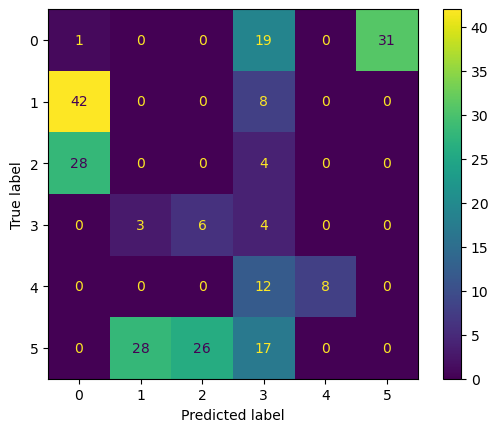

Prediction labels after reordering:
{0: 31, 1: 71, 2: 8, 3: 32, 4: 64, 5: 31}

Confusion matrix after reordering columns:


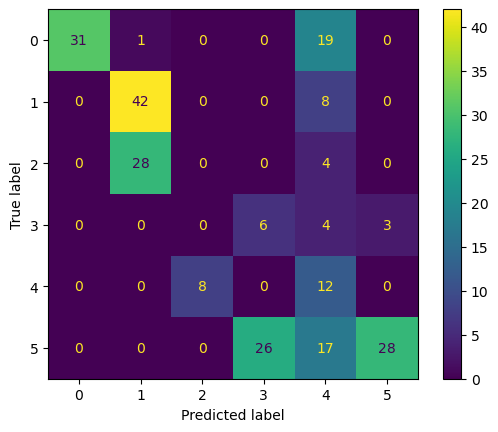

Metrics scores:
Accuracy: 0.5021097046413502
Precision: 0.4782958503710435
Silhouette_score: 0.2908071534179111
F1 score: 0.42528549953879285


**Batch2**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 41, 1: 99, 2: 80, 3: 106, 4: 525, 5: 4} 

Prediction labels:
{0: 166, 1: 135, 2: 263, 3: 74, 4: 117, 5: 100}

Confusion matrix:


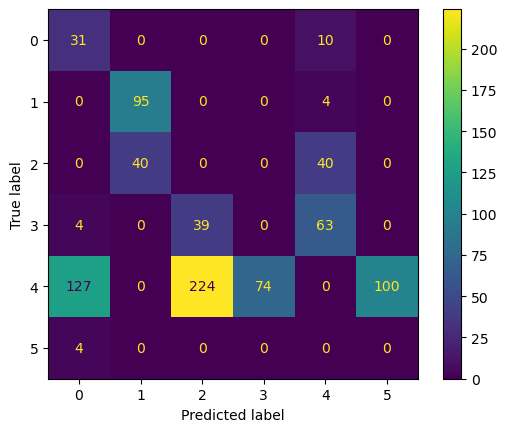

Prediction labels after reordering:
{0: 166, 1: 135, 2: 74, 3: 117, 4: 263, 5: 100}

Confusion matrix after reordering columns:


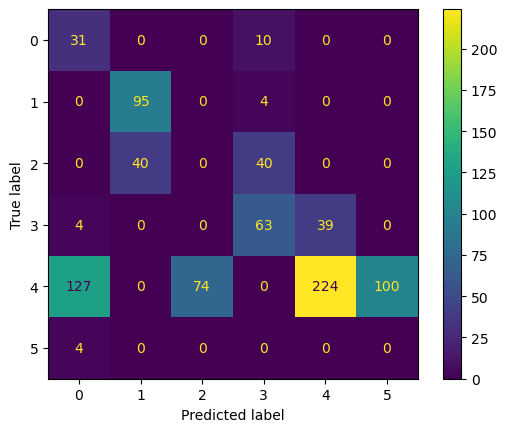

Metrics scores:
Accuracy: 0.4830409356725146
Precision: 0.38010387612216984
Silhouette_score: 0.29832751044465555
F1 score: 0.37417217674746034


**Batch3**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 293, 1: 463, 2: 215, 3: 238, 4: 84} 

Prediction labels:
{0: 79, 1: 368, 2: 229, 3: 118, 4: 338, 5: 161}

Confusion matrix:


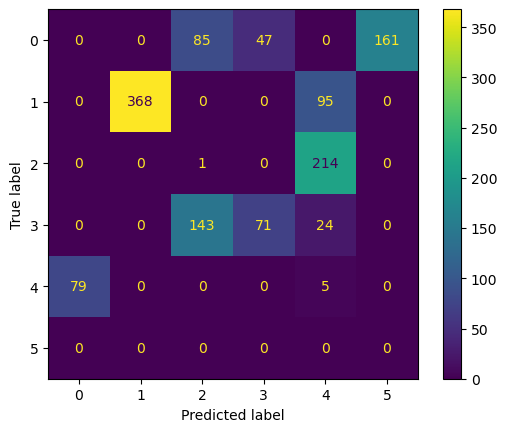

Prediction labels after reordering:
{0: 161, 1: 368, 2: 338, 3: 229, 4: 79, 5: 118}

Confusion matrix after reordering columns:


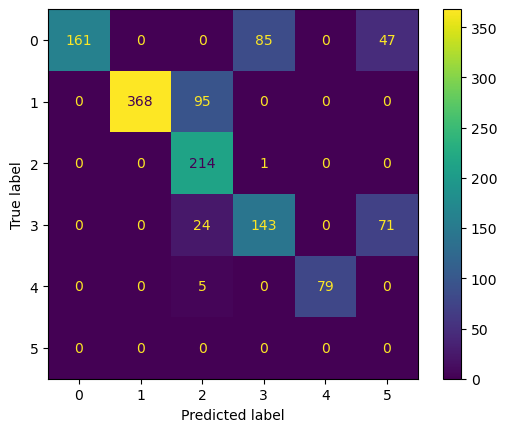

Metrics scores:
Accuracy: 0.7463263727764888
Precision: 0.7095983738576953
Silhouette_score: 0.5287250509404672
F1 score: 0.6584393459397648


**Batch4**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 27, 1: 34, 2: 12, 3: 18, 4: 12} 

Prediction labels:
{0: 18, 1: 30, 2: 18, 3: 12, 4: 5, 5: 20}

Confusion matrix:


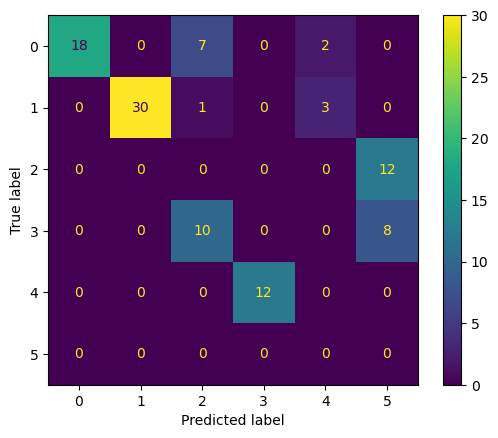

Prediction labels after reordering:
{0: 18, 1: 30, 2: 20, 3: 18, 4: 12, 5: 5}

Confusion matrix after reordering columns:


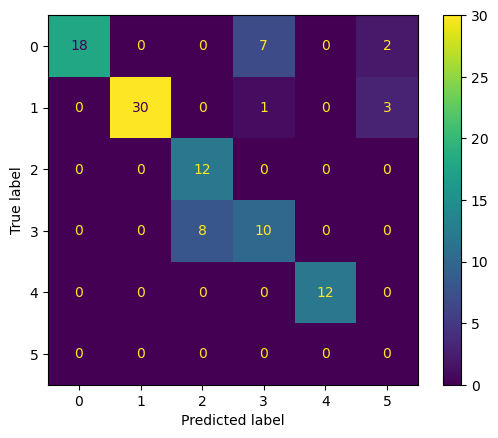

Metrics scores:
Accuracy: 0.7961165048543689
Precision: 0.6925925925925926
Silhouette_score: 0.5999971487982497
F1 score: 0.6738425925925925


**Batch5**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{1: 18, 2: 20, 3: 45, 4: 55} 

Prediction labels:
{0: 45, 1: 30, 2: 18, 3: 18, 4: 10, 5: 17}

Confusion matrix:


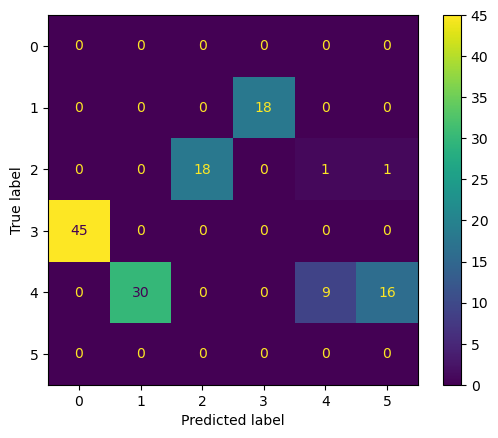

Prediction labels after reordering:
{0: 10, 1: 18, 2: 18, 3: 45, 4: 30, 5: 17}

Confusion matrix after reordering columns:


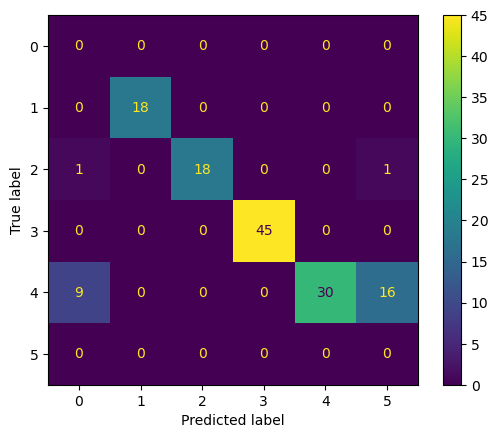

Metrics scores:
Accuracy: 0.8043478260869565
Precision: 0.6666666666666666
Silhouette_score: 0.5981442761493249
F1 score: 0.6088751289989681


**Batch6**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 440, 1: 441, 2: 103, 3: 8, 4: 351, 5: 449} 

Prediction labels:
{0: 468, 1: 567, 2: 221, 3: 298, 4: 98, 5: 140}

Confusion matrix:


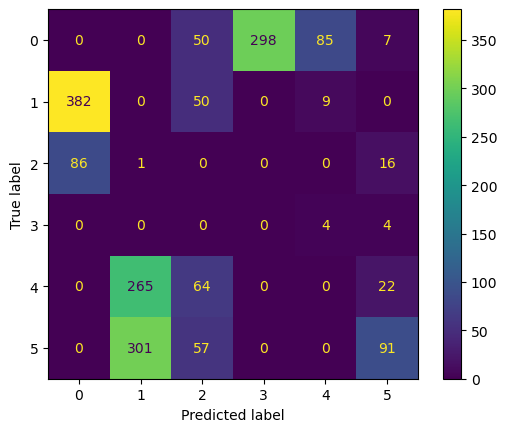

Prediction labels after reordering:
{0: 298, 1: 468, 2: 140, 3: 98, 4: 221, 5: 567}

Confusion matrix after reordering columns:


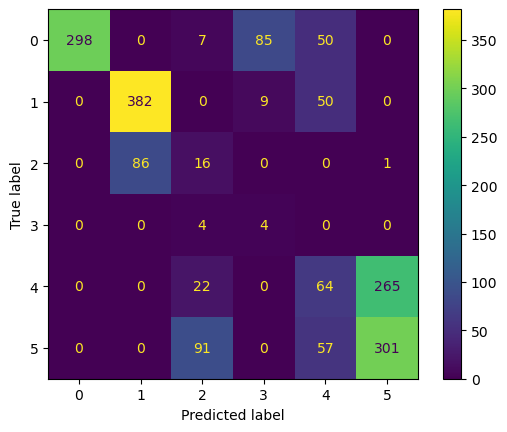

Metrics scores:
Accuracy: 0.5943080357142857
Precision: 0.4652997191279171
Silhouette_score: 0.6176225395764308
F1 score: 0.44525449566879244


**Batch7**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 77, 1: 165, 2: 338, 3: 545, 4: 128, 5: 563} 

Prediction labels:
{0: 323, 1: 294, 2: 347, 3: 262, 4: 248, 5: 342}

Confusion matrix:


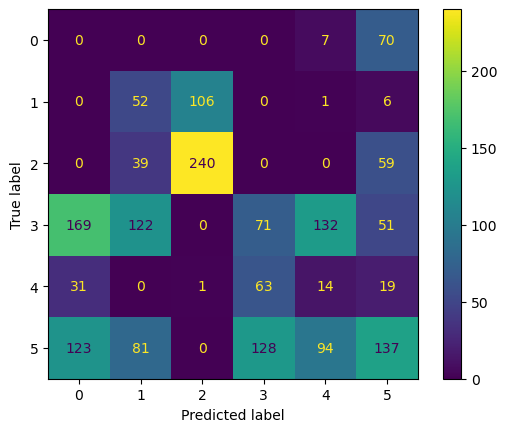

Prediction labels after reordering:
{0: 342, 1: 294, 2: 347, 3: 323, 4: 262, 5: 248}

Confusion matrix after reordering columns:


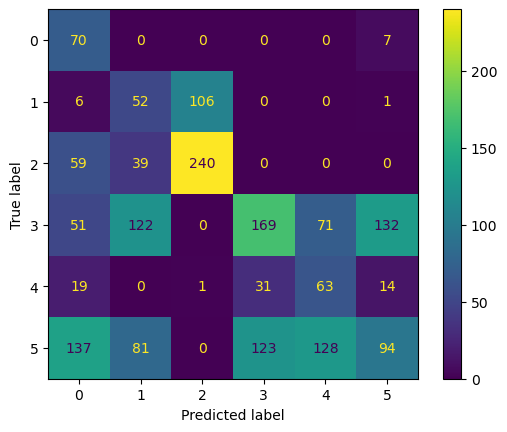

Metrics scores:
Accuracy: 0.3788546255506608
Precision: 0.3693169749570711
Silhouette_score: 0.28637762580255366
F1 score: 0.3676214579645585


**Batch8**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{1: 29, 2: 26, 3: 6, 4: 114, 5: 6} 

Prediction labels:
{0: 68, 1: 43, 2: 21, 3: 13, 4: 29, 5: 7}

Confusion matrix:


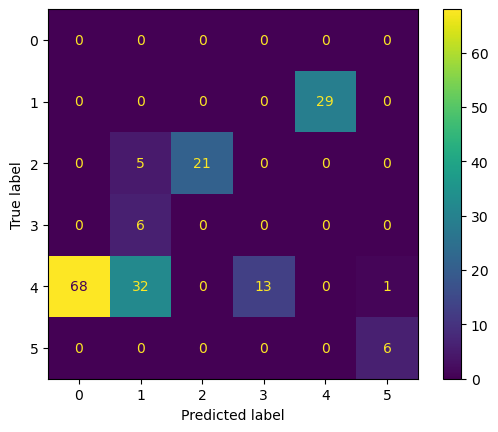

Prediction labels after reordering:
{0: 13, 1: 29, 2: 21, 3: 43, 4: 68, 5: 7}

Confusion matrix after reordering columns:


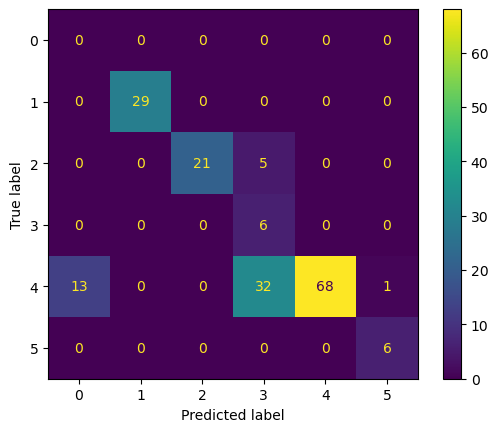

Metrics scores:
Accuracy: 0.7182320441988951
Precision: 0.6661129568106312
Silhouette_score: 0.6188530210166115
F1 score: 0.6348074417983233


**Batch9**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 58, 1: 51, 2: 96, 3: 47, 4: 19, 5: 98} 

Prediction labels:
{0: 58, 1: 96, 2: 51, 3: 54, 4: 26, 5: 84}

Confusion matrix:


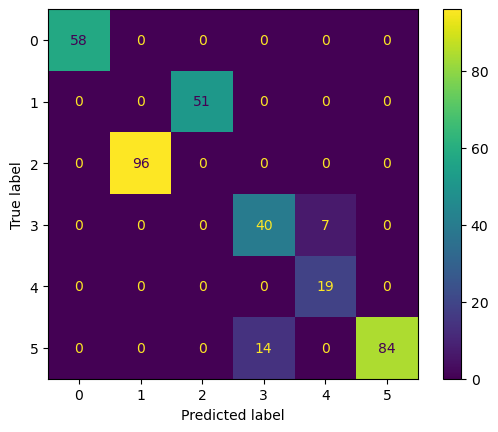

Prediction labels after reordering:
{0: 58, 1: 51, 2: 96, 3: 54, 4: 26, 5: 84}

Confusion matrix after reordering columns:


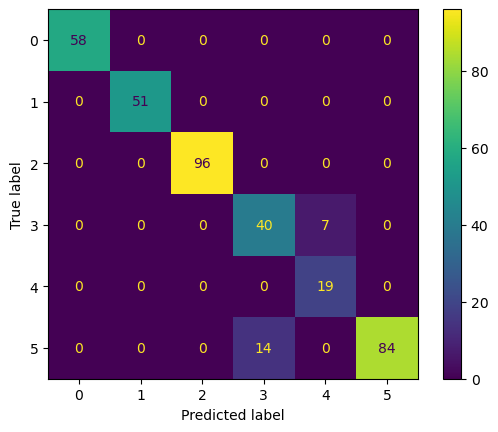

Metrics scores:
Accuracy: 0.943089430894309
Precision: 0.9119183285849952
Silhouette_score: 0.6428807773817453
F1 score: 0.9266000959070265


**Batch10**

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


True lables:
{0: 108, 1: 215, 2: 179, 3: 479, 4: 70, 5: 504} 

Prediction labels:
{0: 281, 1: 180, 2: 442, 3: 298, 4: 196, 5: 158}

Confusion matrix:


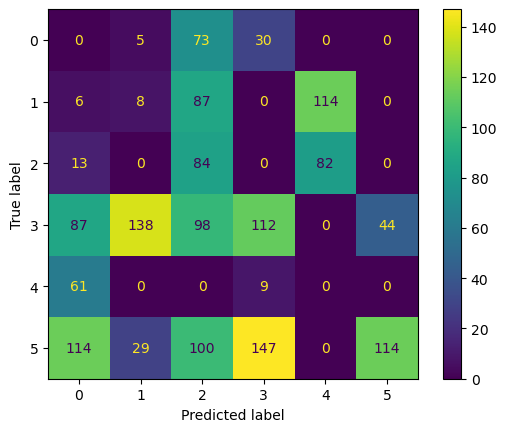

Prediction labels after reordering:
{0: 158, 1: 196, 2: 442, 3: 180, 4: 281, 5: 298}

Confusion matrix after reordering columns:


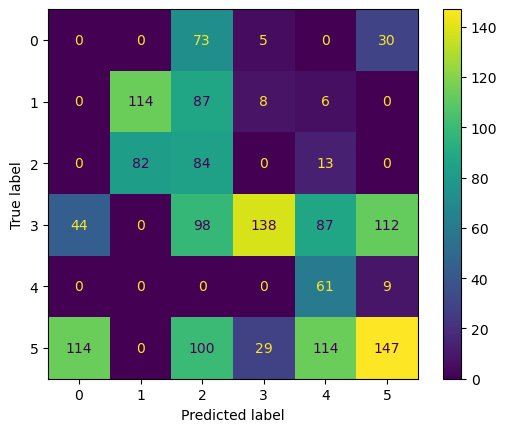

Metrics scores:
Accuracy: 0.3498392282958199
Precision: 0.3747858349557507
Silhouette_score: 0.2965287459434216
F1 score: 0.32637570061774723


In [446]:
# GaussianHMM - after anomaly
accuracy_HMM_after_anomaly = []
precision_HMM_after_anomaly = []
silhouette_HMM_after_anomaly = []
f1_score_HMM_after_anomaly = []
external_variables_values_after_anomaly = []

HMM = hmm.GaussianHMM(n_components=6)
accuracy_HMM_after_anomaly, precision_HMM_after_anomaly, silhouette_HMM_after_anomaly, f1_score_HMM_after_anomaly, external_variables_values_after_anomaly = resultsPerModel(dfs, HMM, False, True, external_variables_keys)

In [447]:
# check if anomaly detection improves the HMM clustering algorithem by calculate each average metrics

accuracy_HMM_after_anomaly_average = np.average(accuracy_HMM_after_anomaly)
precision_HMM_after_anomaly_average = np.average(precision_HMM_after_anomaly)
silhouette_HMM_after_anomaly_norm = [(val+1) / 2 for val in silhouette_HMM_after_anomaly]
silhouette_HMM_after_anomaly_norm_average = np.average(silhouette_HMM_after_anomaly_norm)
f1_score_HMM_after_anomaly_average = np.average(f1_score_HMM_after_anomaly)
HMM_metrics_after_anomaly_average = np.average([accuracy_HMM_after_anomaly_average, precision_HMM_after_anomaly_average, silhouette_HMM_after_anomaly_norm_average, f1_score_HMM_after_anomaly_average])
print("HMM metrics after anomaly detection average:", HMM_metrics_after_anomaly_average)

HMM metrics after anomaly detection average: 0.6215340435810474


In [449]:
# Table for PDF - see correlation after anomaly detaction

index_names = ["Batch1", "Batch2", "Batch3", "Batch4", "Batch5", "Batch6", "Batch7", "Batch8", "Batch9", "Batch10"]

table = []

for idx in range(len(index_names)):
    table.append([f'({feature}, {value})' for feature, value in zip(external_variables_keys[idx], external_variables_values_after_anomaly[idx])])

print(tabulate(table, headers=["Feature 1st", "Feature 2nd", "Feature 3rd"], showindex=index_names, tablefmt="latex"))

\begin{tabular}{llll}
\hline
         & Feature 1st                       & Feature 2nd                       & Feature 3rd                       \\
\hline
 Batch1  & (Feature\_66, 0.7062529607235046)  & (Feature\_65, 0.7039702303753989)  & (Feature\_9, 0.34452353943280367)  \\
 Batch2  & (Feature\_72, 0.2167536061660177)  & (Feature\_16, 0.19941650887824752) & (Feature\_9, 0.08506667190126228)  \\
 Batch3  & (Feature\_101, 0.863065753903515)  & (Feature\_100, 0.8497711271856487) & (Feature\_109, 0.8433644008672184) \\
 Batch4  & (Feature\_108, 0.8045694972234346) & (Feature\_100, 0.7969600860984662) & (Feature\_124, 0.7574049910907877) \\
 Batch5  & (Feature\_9, 0.534714191050047)    & (Feature\_108, 0.4841125458554326) & (Feature\_1, 0.4677118233120063)   \\
 Batch6  & (Feature\_109, 0.7312201431740545) & (Feature\_125, 0.7240555811076727) & (Feature\_53, 0.7090790020424355)  \\
 Batch7  & (Feature\_109, 0.7770579038167599) & (Feature\_101, 0.7670647310153487) & (Feature\_108, 0.7668

In [468]:
# check precision after anomaly
print(np.array(precision_HMM)-np.array(precision_HMM_after_anomaly))

[ 0.00861805  0.19103199 -0.02872053 -0.0476469   0.04398158  0.12146282
  0.29367033  0.00546788 -0.20995997  0.11588497]


In [470]:
import scipy.stats as stats

# perform t-test
t_stat, p_value = stats.ttest_ind(precision_HMM_after_anomaly,precision_HMM)

# print results
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.774860371090396
p-value: 0.4484821577612532
